# Trump vs Harris debate analysis with with Python

In [66]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns 

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


In [67]:
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

from nltk.corpus import stopwords
stopwords=stopwords.words('english')

In [68]:
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\berid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Get data and preprocess

In [69]:
url="https://www.rev.com/blog/transcripts/harris-vs-trump-presidential-debate"
html=requests.get(url,headers=headers).content
soup=BeautifulSoup(html,'html.parser')

In [70]:
lines=[]

for element in soup.select('div[class="fl-callout-text"] p'):
    line=element.text.replace('\n','').strip()
    lines.append(line)

In [71]:
lines=lines[lines.index('So let’s now welcome the candidates to the stage, Vice President Kamala Harris and President Donald Trump.')-1:]

In [72]:
df=pd.DataFrame(lines,columns=['Lines'])

In [73]:
seconds_passed=[]

for line in lines:

    time=line.split('(')[-1].split(')')[0]

    if ':' in line and '(' in line and time.count(':')==1:
        min=int(time.split(':')[0])
        sec=int(time.split(':')[1])
        second=min*60+sec
        seconds_passed.append(second)
    elif ':' in line and '(' in line and time.count(':')==2:
        hour=int(time.split(':')[0])
        min=int(time.split(':')[1])
        sec=int(time.split(':')[2])
        second=hour*3600+min*60+sec
        seconds_passed.append(second)
    else:
        seconds_passed.append(None)


df['Seconds Passed']=seconds_passed

df['Seconds Passed']=df['Seconds Passed'].fillna(method='ffill')

In [74]:
speakers=[]

for line in df['Lines']:
    if line.endswith('):'):
        speaker=line.split('(')[0].strip()
        speakers.append(speaker)
    else:
        speakers.append(None)

df['Speaker']=speakers
df['Speaker']=df['Speaker'].fillna(method='ffill')

In [75]:
df=df[df['Lines'].str.endswith('):')==False].reset_index(drop=True)

In [76]:
df=df[df['Speaker'].str.contains('Speaker')==False].reset_index(drop=True)

In [77]:
df=df[df['Lines'].str.contains('right back')==False] # remove break announcemenet lines

In [78]:
df['Lines']=df['Lines'].apply(lambda x:
                  x.split(')')[-1].strip() if ')' in x and ':' in x else x
                  )

In [79]:
df['Seconds Spoken']=df['Seconds Passed'].shift(-1)-df['Seconds Passed']

In [80]:
df['Speech Order']=df.groupby('Speaker')['Lines'].transform('cumcount')+1


In [81]:
df['Words Spoken']=[len(text.split(' ')) for text in df['Lines']]
df['Seconds Per Word']=df['Seconds Spoken']/df['Words Spoken']

df=df[df['Seconds Per Word']<=2].reset_index(drop=True)

In [82]:
def line_sentiment_scores(line):
    line_tokenized=nltk.word_tokenize(line)
    line_lower=[w.lower() for w in line_tokenized]
    line_lemmatized=[lemmatizer.lemmatize(w) for w in line_lower]
    line_filtered=[w for w in line_lemmatized if w not in stopwords]
    final_line=' '.join(line_filtered)
    
    score=sia.polarity_scores(final_line)
    return score

In [83]:
scores = []

for i,line in enumerate(df['Lines']):
    if isinstance(line, str):
        scores.append(line_sentiment_scores(line))
    else:
        scores.append(None)

In [84]:
df['Positive Sentiment Scores']=[score['pos'] if isinstance(score,dict) else None for score in scores]
df['Negative Sentiment Scores']=[score['neg'] if isinstance(score,dict) else None for score in scores]
df['Compound Sentiment Scores']=[score['compound'] if isinstance(score,dict) else None for score in scores]

In [85]:
df=df[['Speaker','Lines','Speech Order','Seconds Passed','Seconds Spoken','Words Spoken','Seconds Per Word','Positive Sentiment Scores','Negative Sentiment Scores','Compound Sentiment Scores']]

# Data visualization

In [86]:
df

,Speaker,Lines,Speech Order,Seconds Passed,Seconds Spoken,Words Spoken,Seconds Per Word,Positive Sentiment Scores,Negative Sentiment Scores,Compound Sentiment Scores
0,David Muir,So let’s now welcome the candidates to the sta...,1,137.0,13.0,17,0.764706,0.231,0.000,0.4588
1,Kamala Harris,Kamala Harris. Let’s have a good debate.,1,150.0,2.0,7,0.285714,0.420,0.000,0.4404
2,Donald Trump,Nice to see you. Have fun.,1,152.0,1.0,6,0.166667,0.859,0.000,0.7269
3,Kamala Harris,Thank you.,2,153.0,2.0,2,1.000000,1.000,0.000,0.3612
4,David Muir,Welcome to you both. It’s wonderful to have yo...,2,155.0,3.0,18,0.166667,0.908,0.000,0.8720
...,...,...,...,...,...,...,...,...,...,...
299,Lindsey Davis,"Vice President Harris, thank you. President Tr...",41,6169.0,4.0,7,0.571429,0.333,0.000,0.3612
300,Donald Trump,"So she just started by saying, she’s going to ...",111,6173.0,44.0,153,0.287582,0.274,0.017,0.9549
301,Donald Trump,Germany tried that and within one year they we...,112,6217.0,51.0,155,0.329032,0.219,0.298,-0.8555
302,Donald Trump,I rebuilt our entire military. She gave a lot ...,113,6268.0,26.0,66,0.393939,0.000,0.398,-0.9477


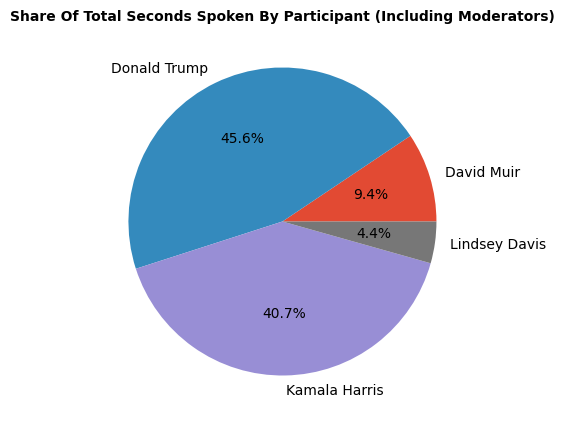

In [87]:
plt.figure(figsize=(7,5))
df.groupby('Speaker')['Seconds Spoken'].sum().plot.pie(autopct='%.1f%%',label='')
plt.title('Share Of Total Seconds Spoken By Participant (Including Moderators)',fontweight='bold',size=10)

plt.show()

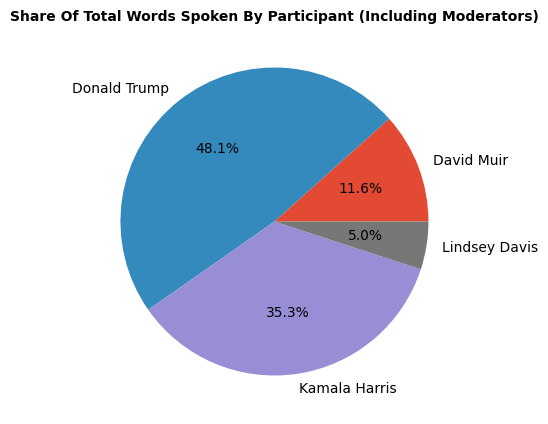

In [88]:
plt.figure(figsize=(7,5))
df.groupby('Speaker')['Words Spoken'].sum().plot.pie(autopct='%.1f%%',label='')
plt.title('Share Of Total Words Spoken By Participant (Including Moderators)',fontweight='bold',size=10)

plt.show()

Text(0.5, 1.0, 'Frequency Distribution Of "Seconds Per Word" By Candidate')

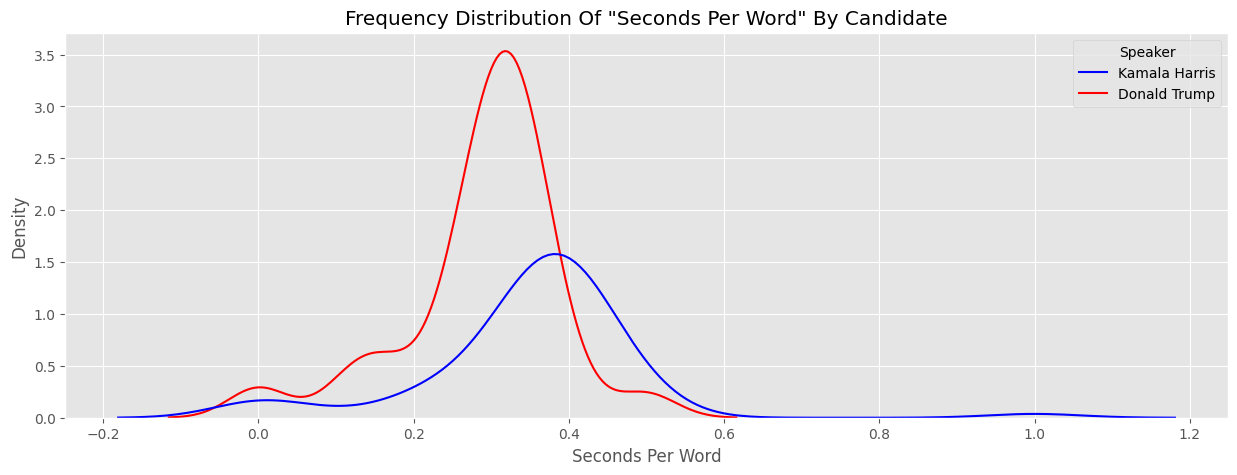

In [89]:
plt.figure(figsize=(15,5))
sns.kdeplot(
    df[df['Speaker'].isin(['Donald Trump','Kamala Harris'])],
    x='Seconds Per Word',
    hue='Speaker',palette=['Blue','Red']
    )

plt.title('Frequency Distribution Of "Seconds Per Word" By Candidate')

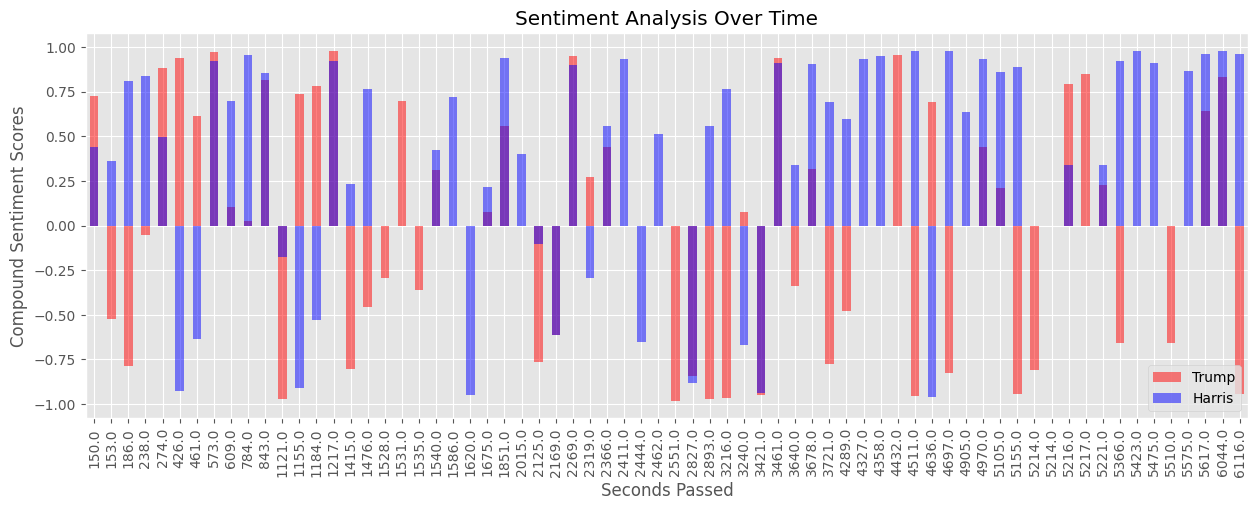

In [90]:
g=df.groupby(['Speaker','Speech Order'])['Compound Sentiment Scores'].mean().reset_index()


fig,ax=plt.subplots(figsize=(15,5))
df[df['Speaker'] == 'Donald Trump'].plot.bar(ax=ax,x='Seconds Passed',y='Compound Sentiment Scores',color='Red',alpha=0.5,label='Trump')
df[df['Speaker'] == 'Kamala Harris'].plot.bar(ax=ax,x='Seconds Passed',y='Compound Sentiment Scores',color='Blue',alpha=0.5,label='Harris')

plt.legend()
plt.title('Sentiment Analysis Over Time')
plt.xlabel('Seconds Passed')
plt.ylabel('Compound Sentiment Scores')
plt.show()




# Used Words Analysis

In [91]:
print('Most frequntly used words by Trump')

pd.Series([word.strip().replace('.','').replace(',','').lower() for text in df[df['Speaker']=='Donald Trump']['Lines'] for word in text.split(' ') if word not in stopwords]).value_counts(ascending=False)[:20]

Most frequntly used words by Trump


i          154
people      78
they        72
and         68
it          65
going       63
country     56
they’re     47
said        45
don’t       41
get         40
she         37
it’s        35
that’s      35
that        33
like        32
we          32
one         32
got         30
but         28
Name: count, dtype: int64

In [92]:
print('Most frequntly used words by Harris')

pd.Series([word.strip().replace('.','').replace(',','').lower() for text in df[df['Speaker']=='Kamala Harris']['Lines'] for word in text.split(' ') if word not in stopwords]).value_counts(ascending=False)[:20]

Most frequntly used words by Harris


i             107
and            60
president      55
people         46
donald         32
trump          31
would          29
let’s          25
american       25
said           24
states         22
you            22
one            21
united         21
plan           19
understand     18
know           18
us             17
going          17
well           17
Name: count, dtype: int64

##### Most frequent 3 word combination used by each candidate

In [93]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.lower()  
    return text

def return_bigrams(filtered):
    text = ' '.join(filtered['Lines'].dropna())

    cleaned_text = clean_text(text)

    tokens = word_tokenize(cleaned_text)

    tokens = [word for word in tokens if word not in stopwords]

    bigrams = list(ngrams(tokens, 3)) #witch from bigram to trigram

    bigram_counts = Counter(bigrams)

    most_common_bigrams = bigram_counts.most_common(10)

    return most_common_bigrams



bigram_dict={}
for speaker in ['Donald Trump','Kamala Harris']:
    filtered=df[df['Speaker']==speaker]
    bigrams=return_bigrams(filtered)
    bigram_dict[speaker]=bigrams

for speaker, bigrams in bigram_dict.items():
    print(f'Speaker: {speaker}')
    freq_dict={}
    for bigram in bigrams:
        frequency=bigram[1]
        words_combination=' '.join([w for w in bigram[0]])
        freq_dict[words_combination]=frequency
    print(freq_dict)
    print('\n\n')

Speaker: Donald Trump
{'three half years': 6, 'wouldve never happened': 4, 'dont even know': 4, 'people pouring country': 3, 'theyre destroying country': 3, 'nobody thought possible': 3, 'hundreds billions dollars': 3, 'ive never seen': 3, 'millions millions people': 3, 'get student loans': 3}



Speaker: Kamala Harris
{'president united states': 8, 'affordable care act': 7, 'donald trump left': 4, 'trump left us': 4, 'youre going hear': 4, 'left us worst': 3, 'much common separates': 3, 'common separates us': 3, 'lets understand got': 3, 'protections roe v': 3}



